## SingleTopic Embeddings

The assumption that a document belongs to only one topic simplifies the topic modeling without losing generalization.

By assigning documents to the topics, the *semantic embeddings* of the documents is based on the matrix $H$ where element $_H{ij}$ shows the probability of assigning label $i$ to the topic $j$. As noted, this embedding assumes each document is assigned to only one topic. Here is the mapping pipeline from raw documents to the topic embeddings, $H$, and then graph embedding, $G$.

$$
\text{\ documents} \xmapsto{\text{USEv4}}
\vec{X} \xmapsto{\text{UMAP}}
\vec{U} \xmapsto{\text{HDBSCAN}}
\vec{\cnums},\vec{W}\xmapsto{\text{one-hot}}
\vec{Z}\xmapsto{\text{pool}}
\vec{H}\xmapsto{\text{GNN}} \vec{G}
$$

$$
\begin{align*}
Z_{ij} &= \begin{cases}W_i & \text{if }\ \cnums_i=j \ \text{(document } i \text{ is in cluster } j \text{)}\\0 &\text{otherwise}
\end{cases}\\ \\
\vec{W_i} &= p(U_i \in C_i) \\ \\
H_{kj} &= \sum_{i\  \in\ L_k} Z_{ij} \ \ \  \text{(sum-pooling)} \\

\\ \\
|\vec{X}| &\in \R^{\text{|documents|} \times 768}\\
|\vec{U}| &\in \R^{\text{|documents|}\times 5}\\
|\vec{\cnums}| &\in \N^{\text{|documents|}}\\
|\vec{Z}| &\in \R^{\text{|documents|} \times \text{|clusters|}}\\
|\vec{H}| &\in \R^{\text{|labels|} \times {\text{|clusters|}}}
\end{align*}
$$

where $Z_i$ is a single-entry vector representation of document $i$ where the only non-zero element at index $j$ shows the probability of assigning document $i$ to the topic $j$; this membership vector is generated by the unsupervised clustering algorithm during the topic modeling. Note that $\sum_{j} Z_{ij} = 1$ does not always hold as some documents are assigned to one topic with probability of less than one.

Finally, the topic embeddings $H$ of a label $L_j$ is calculated by sum pooling the $Z$-embeddings of its documents.

where $L_k$ is a list of document indices with the label $k$, and $Z_{L_k}$ is the embedding for the label $k$ in the topics space. Note that $L$ sets are not mutually exclusive, so a given document $i$ may appear in multiple $L_j$ s.

In [2]:
# Install requirements

# %pip install -Uq matplotlib seaborn xmltodict sklearn tqdm plotly fastcluster
# %pip install -Uq git+https://github.com/scikit-learn-contrib/hdbscan
# Creating a new conda env is highly recommended because of the conflicting packages.
# %conda activate bertopic

In [3]:
# Imports

%reload_ext autoreload
%autoreload 2

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()  # noqa
import plotly.express as px

from sklearn.metrics.pairwise import cosine_similarity

from tqdm import tqdm; tqdm.pandas()  # noqa

from python.cogtext.datasets.pubmed import PubMedDataLoader
from python.cogtext.reducers import fit_parametric_umap
from python.cogtext.clusterers import fit_hdbscan

In [4]:
# Load data

data_loader = PubMedDataLoader(preprocessed=False, drop_low_occurred_labels=False)
data = data_loader()
# DEBUG data = data.sample(frac=.01, random_state=42)


In [5]:
# Load pretrained embeddings, reduce dimensionality, and cluster

X_file = 'models/universal-sentence-encoder-v4/abstracts_embeddings.npz'
U_file = 'models/umap/abstracts_embeddings_USE-v4-5d.npz'

X = np.load(X_file)['arr_0']
X = X[data.index]
# y = data['label'].astype('category').cat.codes

# reduce dimensionality
U = fit_parametric_umap(X)
print('[REDUCE] Done!')

# cluster
C, W = fit_hdbscan(U)
print('[CLUSTER] Done!')

# store into the dataframe
data['cluster'] = C
data['cluster_score'] = W
data['cluster'].replace({-1:np.nan}, inplace=True)  # discard noise clusters

print('Successfully reduced and clustered document embeddings.')

[REDUCE] Done!
[CLUSTER] Done!
Successfully reduced and clustered document embeddings.


In [6]:
# TODO: extract summary from the clusters (uncomment to run)

# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained('google/pegasus-xsum')
# summarizer = AutoModelForSeq2SeqLM.from_pretrained('google/pegasus-xsum')

# def summarize_cluster(documents):
#   text = '.'.join(documents)
#   tokens = tokenizer(text, truncate=True, padding='longest', return_tensors='pt')
#   summary_tokens = summarizer.generate(**tokens)
#   summary_text = tokenizer.decode(summary_tokens[0])
#   return summary_text

# cluster_summaries = data.groupby('cluster')['abstract'].progress_apply(
#   lambda docs: summarize_cluster(docs.to_list())
# )

In [7]:
# TODO Utility functions

def find_category_by_label(label, pubmed_data):
  return pubmed_data.query('label == @label').iloc[0]['category']

def pivot_by_category(H, H_sim):
  tasks = H.pivot(columns='category').iloc[:, 1].dropna().index
  constructs = H.pivot(columns='category').iloc[:, 0].dropna().index
  categorized_df = H_sim.drop(index=tasks, columns=constructs)
  return categorized_df

def calculate_topic_vectors():
  pass

def merge_similar_topics():
  # perform hdbscan and combine topics if they are clustered together
  pass

def generate_topic_names():
  # TODO tf-idf
  pass

In [8]:
# prepare Z and H matrices

n_clusters = data['cluster'].nunique()
n_docs = data.shape[0]

Z = np.zeros((n_docs, n_clusters))

for i, _, cluster, score in data[['cluster','cluster_score']].reset_index().itertuples():
  if pd.notna(cluster):  # discard the -1 cluster (noise documents)
    Z[i, int(cluster)] = score

# DEBUG confirm that non-zero element is valid and that one-hot encoding works as expected
# assert all(Z.sum(axis=1) == data['cluster_score'])
# assert all((Z.argmax(axis=1) == data['cluster']) | not data['cluster'].ina())

Z = pd.DataFrame(Z, index=data.index)
H = Z.groupby(data['label']).sum()
H['category'] = H.index.to_series().apply(find_category_by_label, pubmed_data=data)

print('[ONE-HOT] Calculated Z and H matrices. Now storing H...')

# store H
H_file = Path('models/cogtext/H_USEv4_UMAP5d_v1.csv.gz')

H_file.parent.mkdir(parents=True, exist_ok=True)  
H.to_csv(H_file, compression='gzip')
print(f'Stored matrix H in {H_file}')


[ONE-HOT] Calculated Z and H matrices. Now storing H...
Stored matrix H in models/cogtext/H_USEv4_UMAP5d_v1.csv.gz


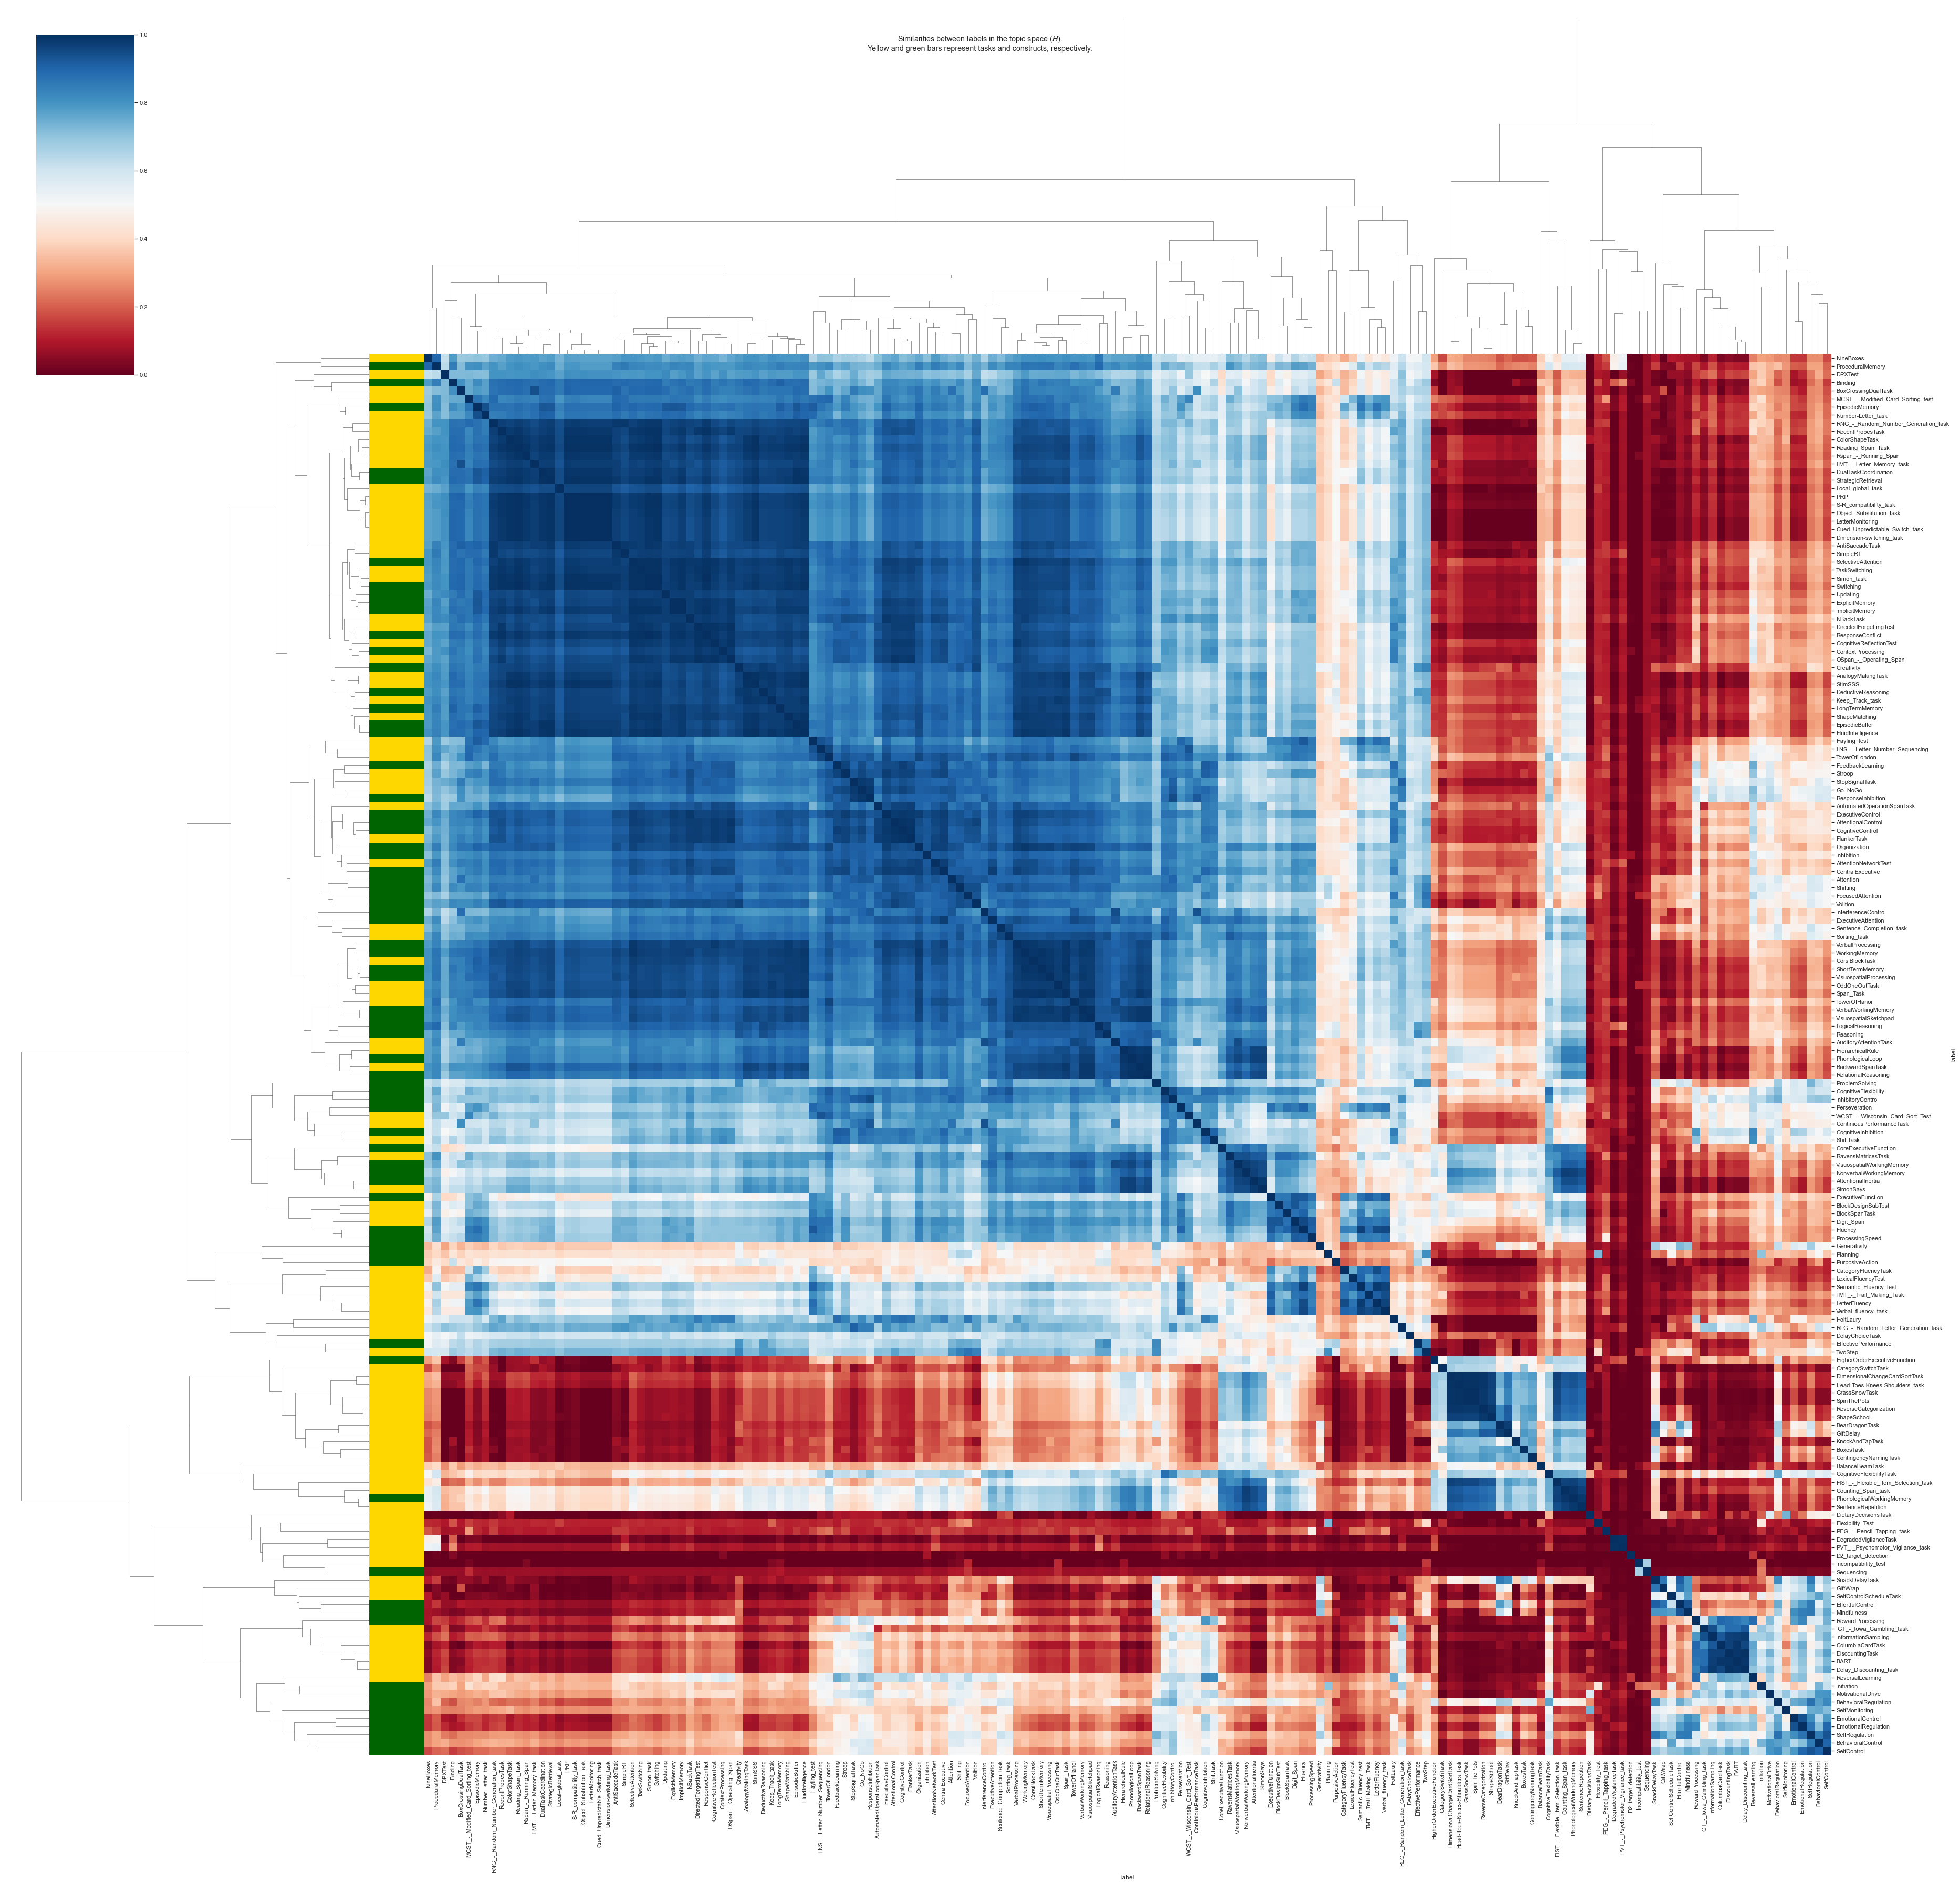

In [9]:
# plot similarity heatmap across all labels

# cosine similarity
H_sim = pd.DataFrame(cosine_similarity(H.drop(columns='category')), index=H.index, columns=H.index)

# mark rows by color
color_cats = H_sim.index.to_series().apply(
    lambda x: data.query('label == @x').iloc[0]['category'])
pallette = ['darkgreen', 'gold']
colors = [pallette[c] for c in color_cats.astype('category').cat.codes.to_list()]

# plot clustered heatmap
sns.clustermap(H_sim, figsize=(52,50), cmap='RdBu', row_colors=colors)
plt.suptitle('Similarities between labels in the topic space ($H$).\n'
             'Yellow and green bars represent tasks and constructs, respectively.')
plt.show()

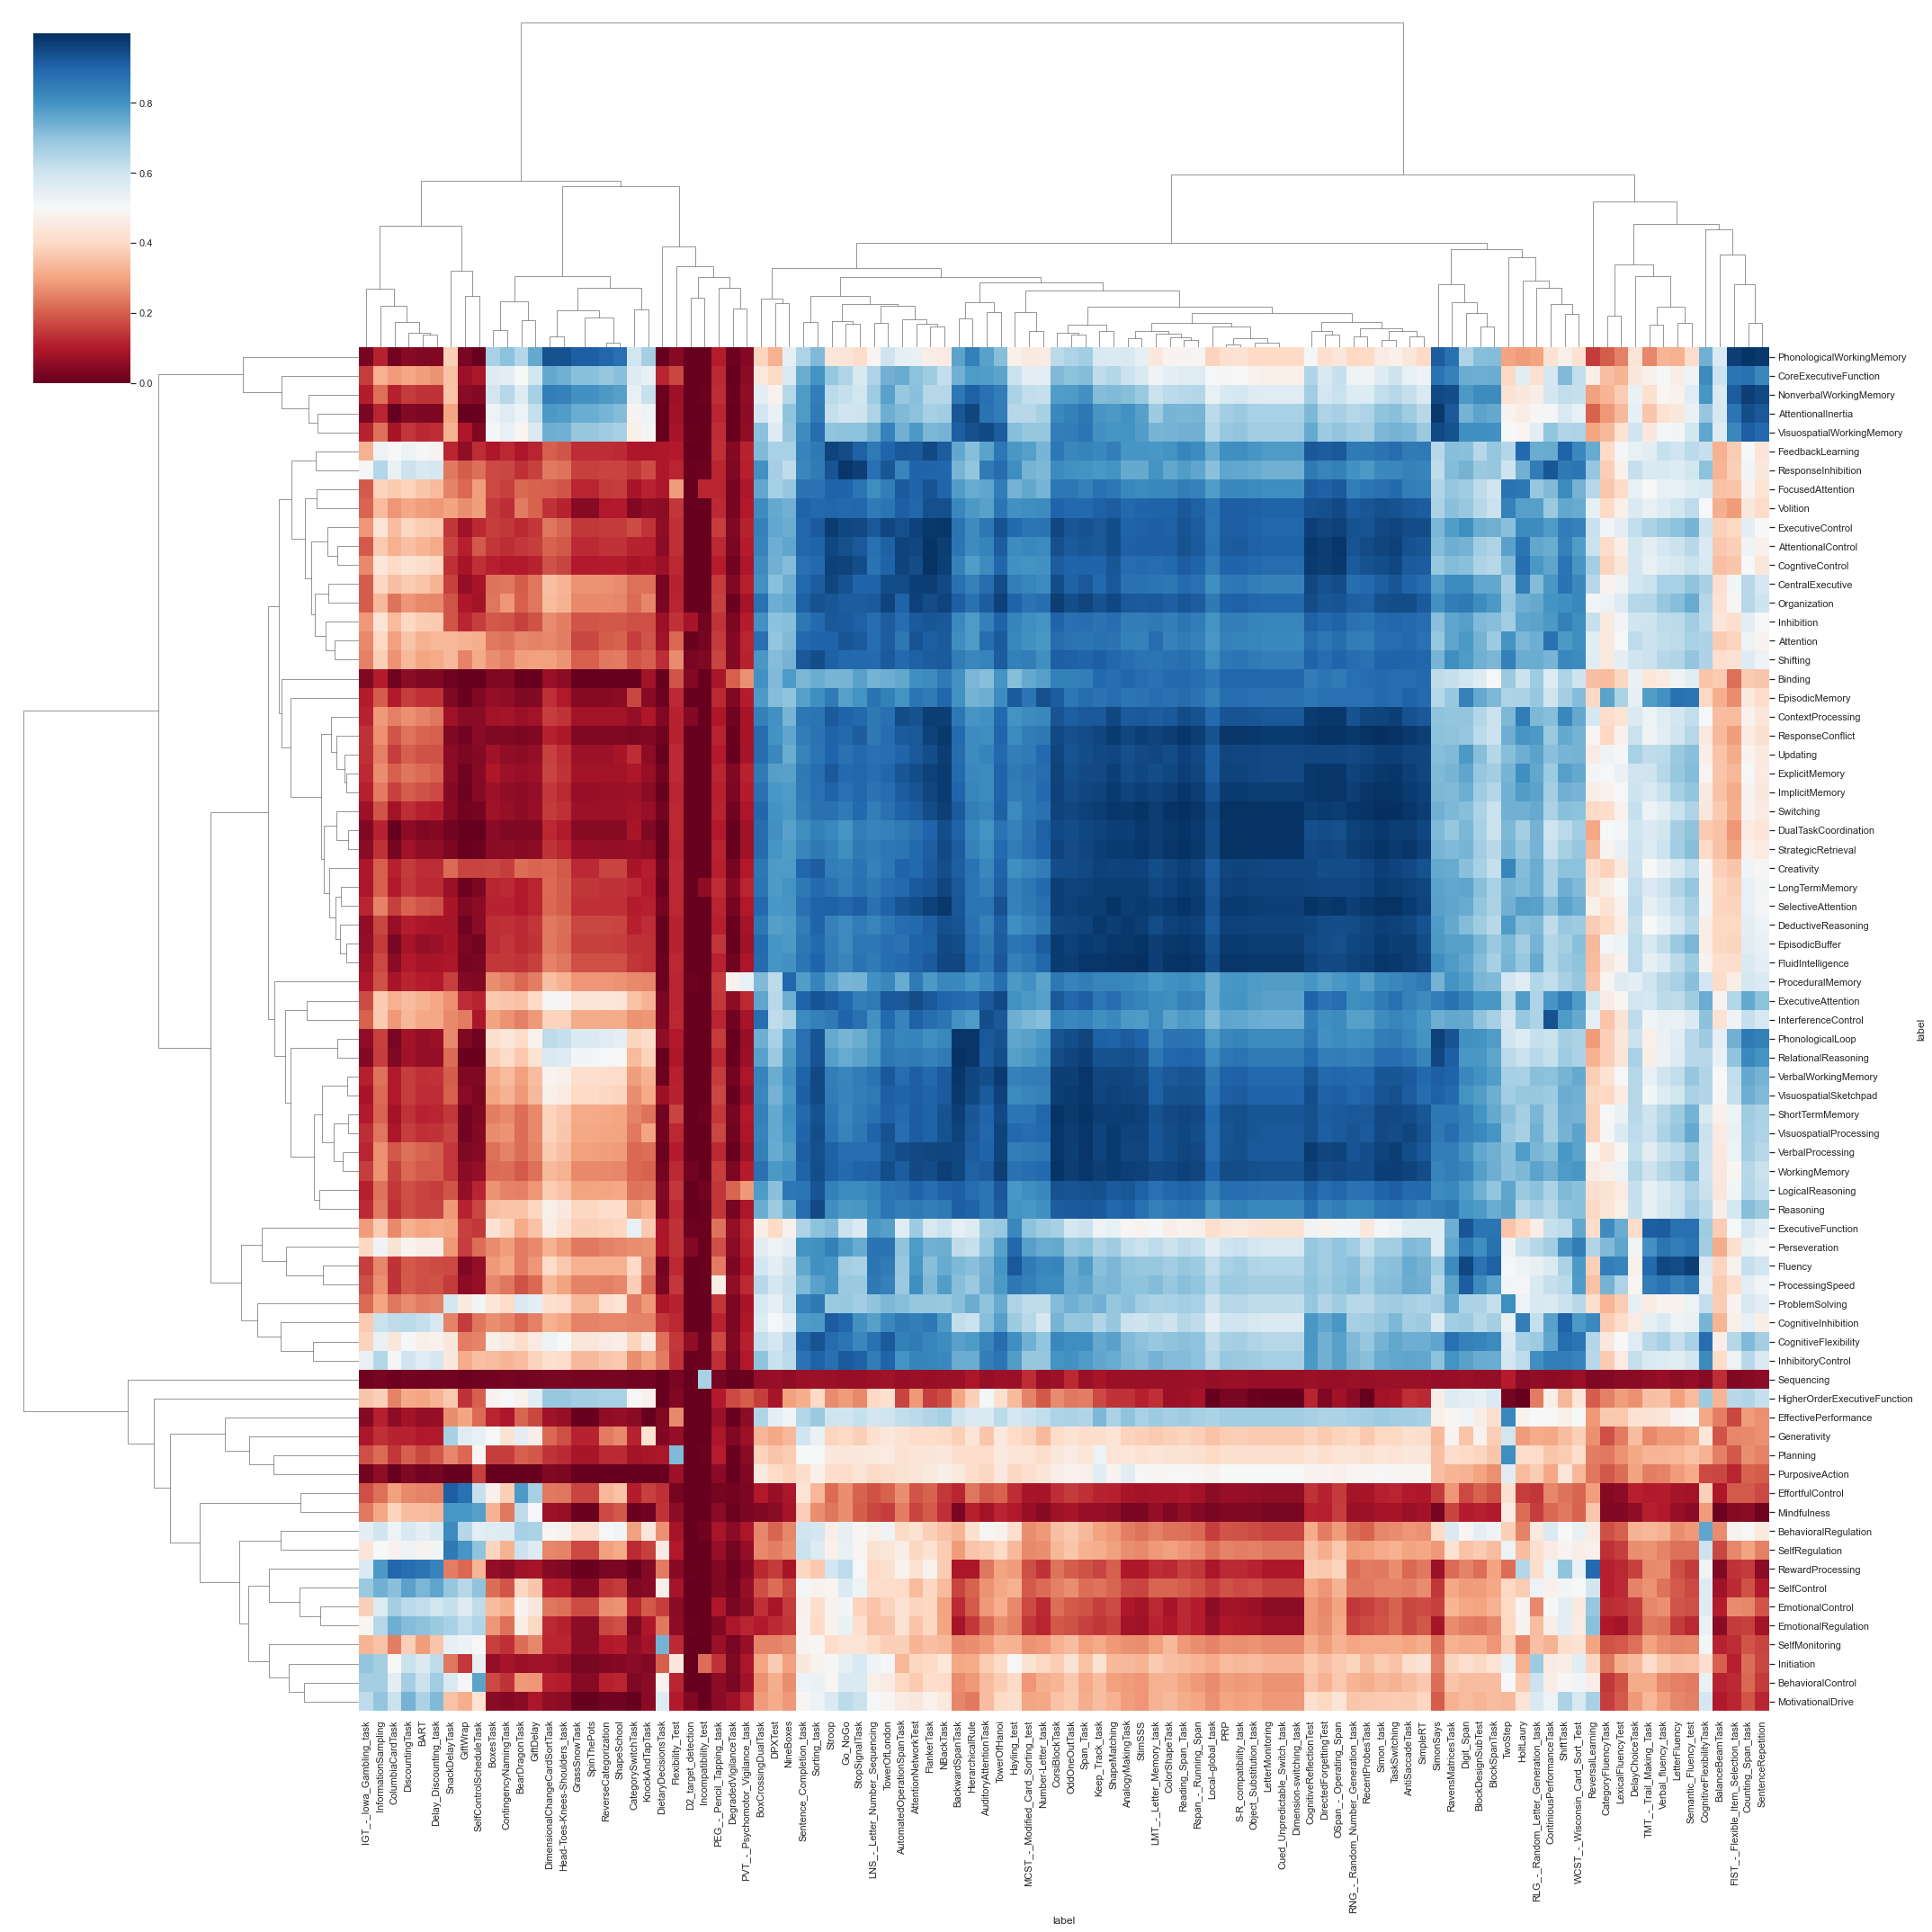

In [10]:
# reshape the heatmap by label type (task vs. construct)

H_sim_categorized = pivot_by_category(H, H_sim)
sns.clustermap(H_sim_categorized, figsize=(30,30), cmap='RdBu')


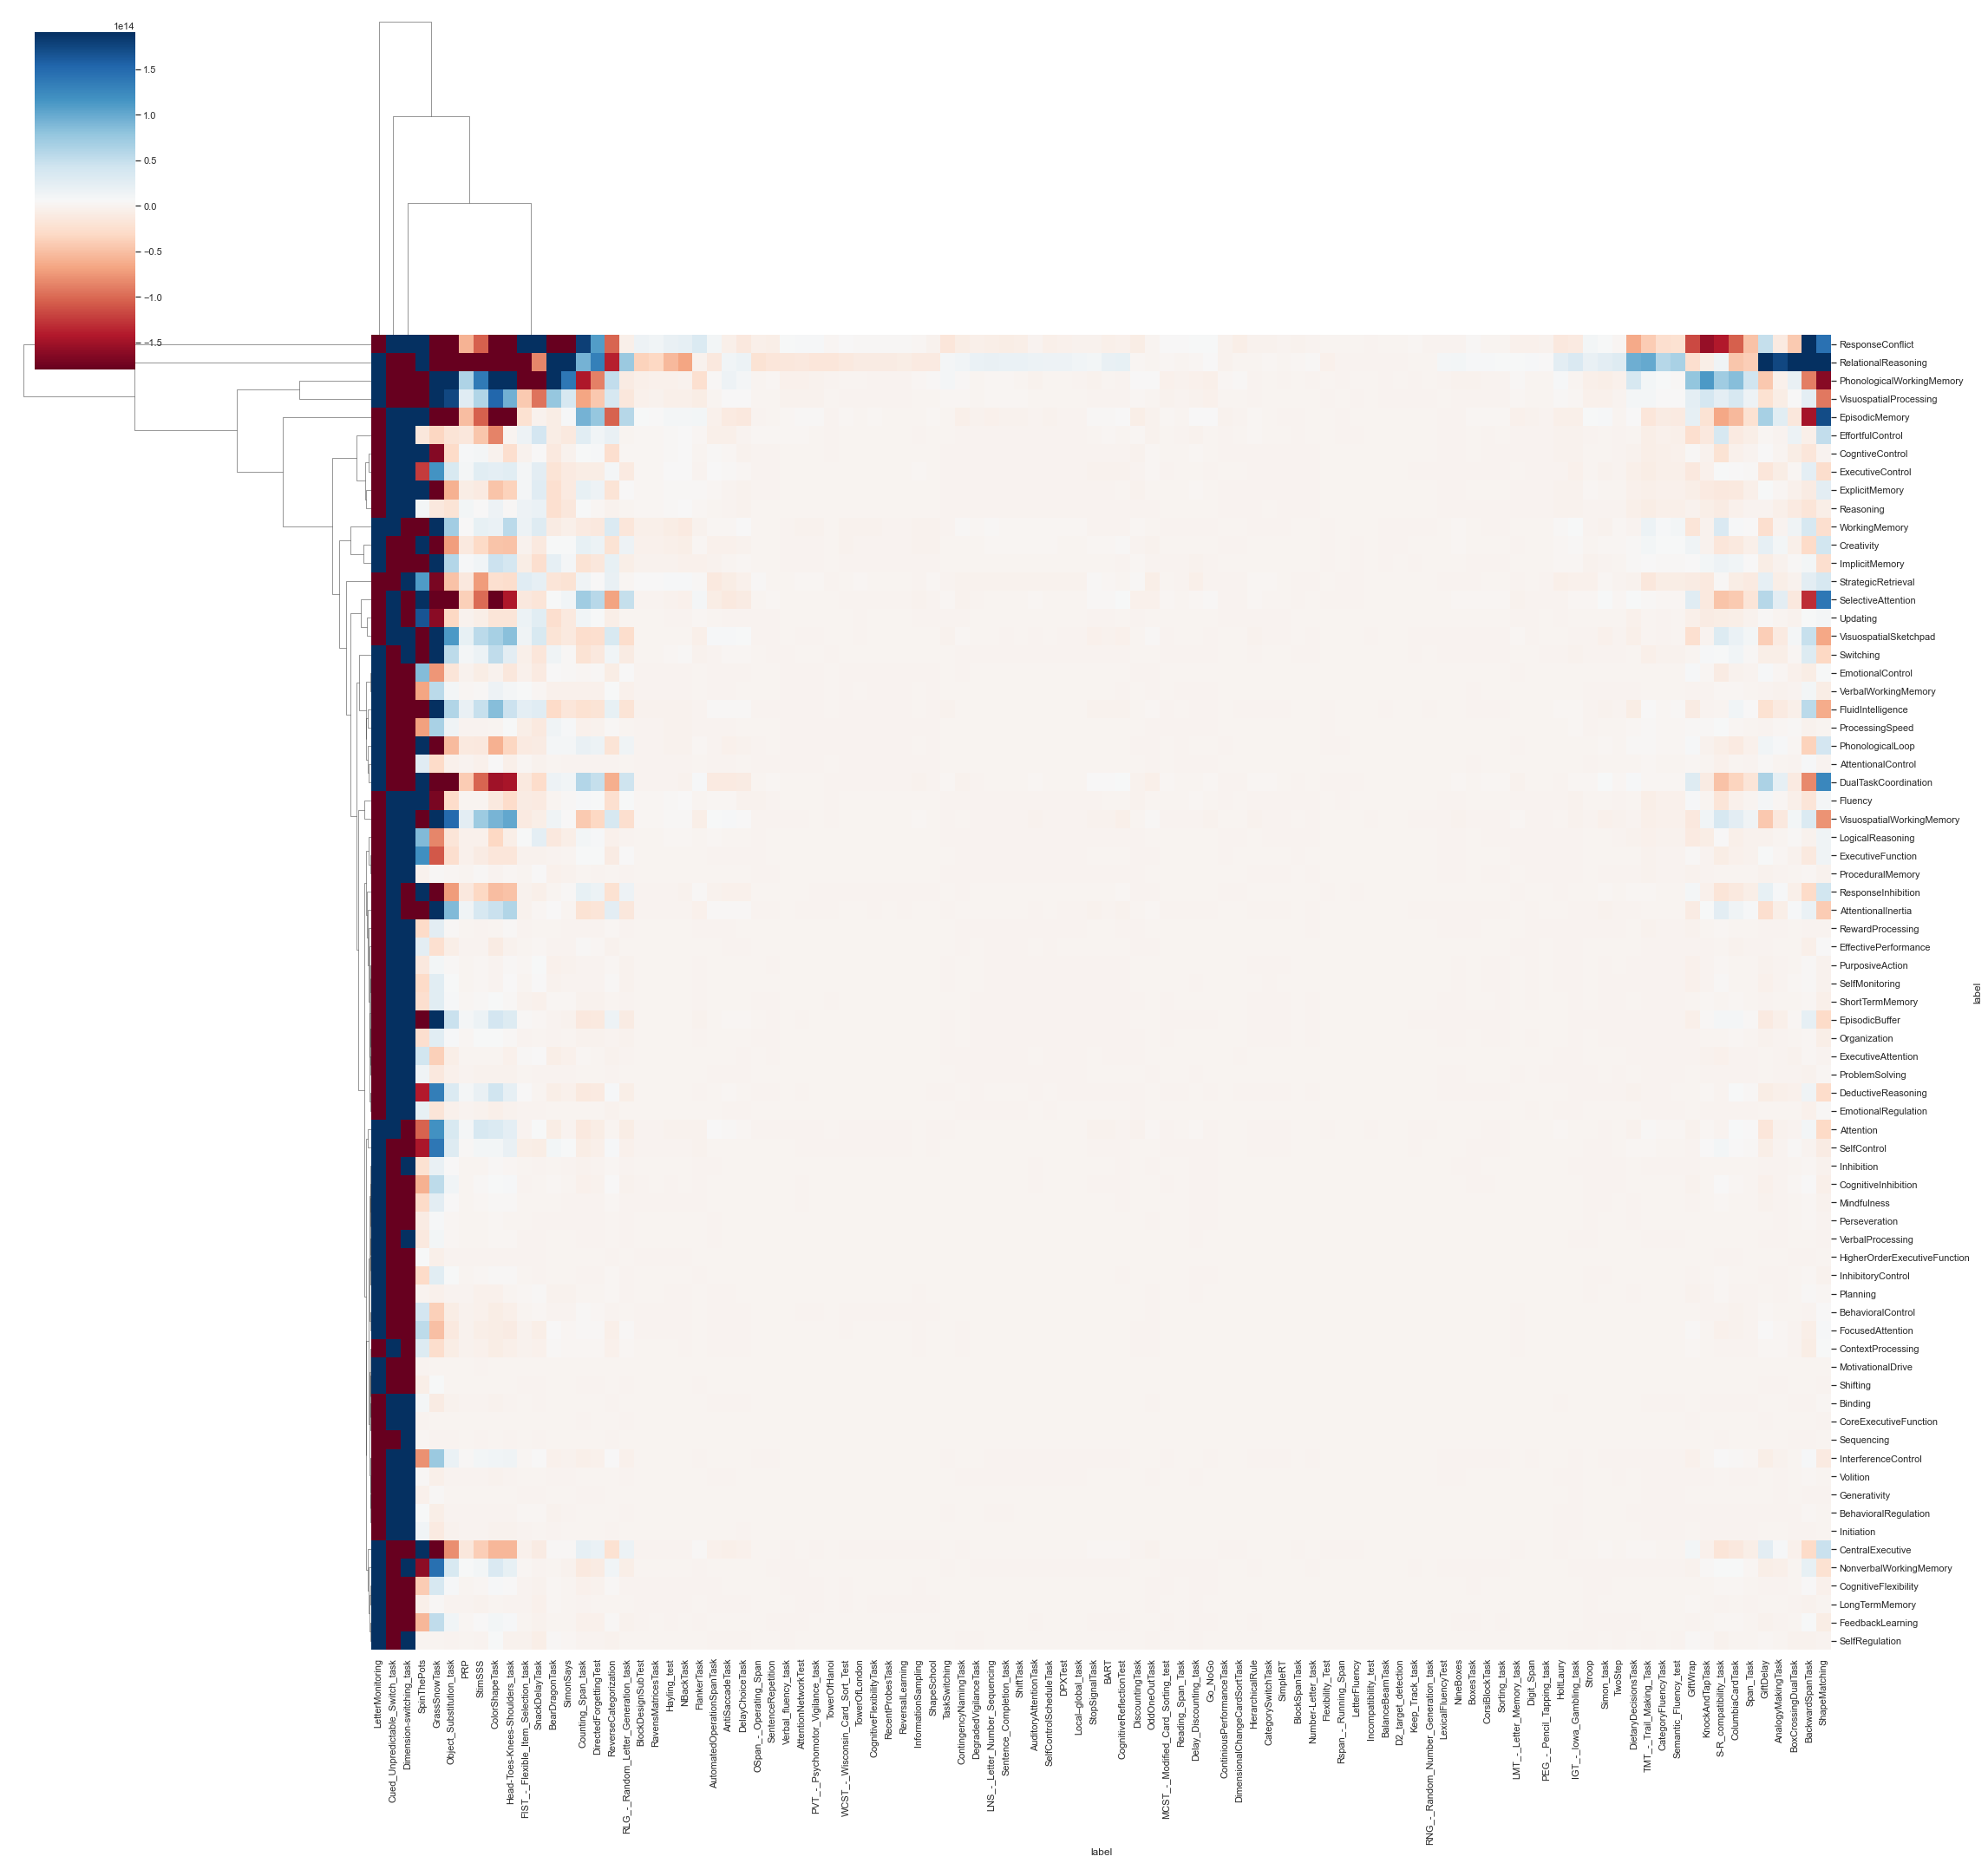

In [11]:
# partial similarity

vals = H_sim.values.T + 0.00001  # to avoid division by zero and non-full rank inversion error
np.linalg.matrix_rank(vals)

coefs = np.corrcoef(vals)
coefs = -np.linalg.inv(coefs)
H_sim_partial = pd.DataFrame(coefs, index=H_sim.index, columns=H_sim.columns)
H_sim_partial = pivot_by_category(H, H_sim_partial)
sns.clustermap(H_sim_partial, figsize=(32,30), cmap='RdBu', robust=True)


In [12]:
# interactive heatmap (similarity of constructs given tasks)

import dash_bio as dashbio

dashbio.Clustergram(
  data=H_sim_categorized.values,
  column_labels=H_sim_categorized.columns.to_list(),
  row_labels=H_sim_categorized.index.to_list(),
  cluster='all',
  height=1500,
  width=1000,
  display_ratio=[0.1, 0.5],
  color_map='Blues',
  hidden_labels=['col'],
  row_dist='cosine',
  col_dist='cosine',
)


In [13]:
import dash_bio as dashbio

dashbio.Clustergram(
  data=H_sim_categorized.values.T + 0.0000001,
  column_labels=H_sim_categorized.T.columns.to_list(),
  row_labels=H_sim_categorized.T.index.to_list(),
  cluster='row',
  height=1500,
  width=1000,
  display_ratio=[0.1, 0.5],
  color_map='Blues',
  hidden_labels=['col'],
  row_dist='cosine',
  col_dist='cosine',
)


In [14]:
import dash_bio as dashbio

H_tasks = H.query('category == "CognitiveTask"').drop(columns='category')

dashbio.Clustergram(
  data=H_tasks.values + .000001,
  column_labels=H_tasks.columns.to_list(),
  row_labels=H_tasks.index.to_list(),
  cluster='row',
  height=1500,
  width=1000,
  display_ratio=[0.1, 0.5],
  color_map='Blues',
  hidden_labels=['col'],
  row_dist='cosine',
  col_dist='cosine',
  standardize='col'
)


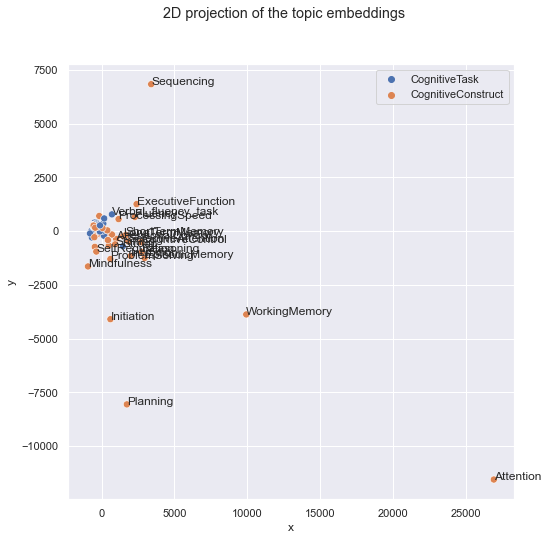

In [15]:
# Project H to 2d and plot

from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
# from umap import UMAP

projector = MDS(n_components=2) # TSNE, PCA, MDS, UMAP

H_2d = projector.fit_transform(H.drop(columns='category'))
H_2d = pd.DataFrame(H_2d, index=H.index, columns=['x', 'y']).reset_index()

colors =  [c for c in color_cats.astype('category')]

_, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(x='x', y='y', data=H_2d, hue=colors, ax=ax, s=50)
plt.suptitle('2D projection of the topic embeddings')

for _, label, x, y in H_2d.itertuples():
  if np.linalg.norm([x, y]) > 1000:
    ax.text(x, y, label, fontsize=12)

plt.show()

In [16]:
import plotly.express as px

px.imshow(H_sim, color_continuous_scale='RdBu', width=1000, height=1000)